Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-b3ef9f61fd2b>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiments', data=Data, palette=colors.values())  # Pass values of the colors dictionary


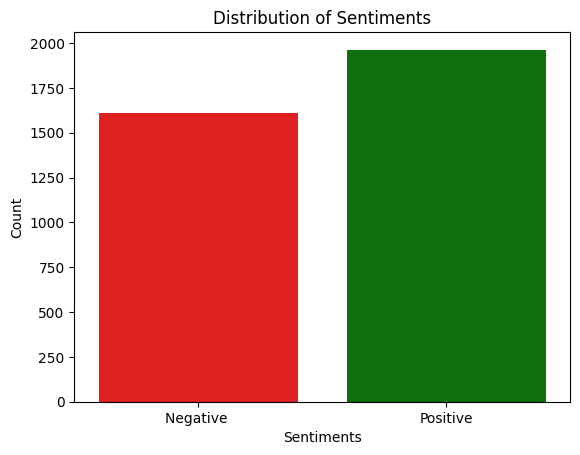

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
import numpy as np
!pip install nltk
import nltk
nltk.download('punkt')
# Load the data
Data = pd.read_excel("/content/drive/MyDrive/Thesis/Product Review Sentiment Analysis.xlsx")

import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette
colors = {'negative': 'red', 'positive': 'green'}

# Plot the count of sentiments with specified palette
sns.countplot(x='Sentiments', data=Data, palette=colors.values())  # Pass values of the colors dictionary

# Set labels and title
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

# Preprocessing Text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Remove single characters
    text = ' '.join([word for word in text.split() if len(word) > 1])
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove leading and trailing spaces
    text = text.strip()
    return text

Data['Reviews'] = Data['Reviews'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

Data['Sentiments'] = Data['Sentiments'].str.lower()

# Remove Bangla stopwords
bangla_stopwords = [
    'এই', 'সে', 'এ', 'তার', 'যে', 'আমাদের', 'তাদের', 'আমরা', 'তোমরা',
    'তুমি', 'তারা', 'যার', 'কোন', 'কিছু', 'এক', 'অনেক', 'অধিক', 'সব',
    'কত', 'কোথায়']
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in bangla_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

Data['Cleaned_Reviews'] = Data['Reviews'].apply(remove_stopwords)
from gensim.models import Word2Vec
# Tokenization
def tokenize_text(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    tokens = word_tokenize(text)
    return tokens

Data['Tokenized_Reviews'] = Data['Reviews'].apply(lambda x: tokenize_text(x) if pd.notnull(x) else x)

# Remove null values
Data = Data.dropna(subset=['Tokenized_Reviews'])


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenize the reviews
Data['Tokenized_Reviews'] = Data['Reviews'].apply(tokenize_text)

# Convert tokenized reviews back to text for TF-IDF vectorization
Data['Tokenized_Text'] = Data['Tokenized_Reviews'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the tokenized text to obtain TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(Data['Tokenized_Text'])



In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, Data['Sentiments'], test_size=0.2, random_state=42)

# Convert sentiments into numerical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.9 MB/s eta 0:00:00


In [13]:
# prompt: generate catboost model for this

from catboost import CatBoostClassifier

# Initialize the CatBoost model
model = CatBoostClassifier(iterations=1000,
                          learning_rate=0.1,
                          depth=6,
                          loss_function='Logloss',
                          eval_metric='Accuracy',
                          l2_leaf_reg=3)

# Train the model
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100,
          plot=True)

# Predict the sentiment on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8582429	test: 0.8531469	best: 0.8531469 (0)	total: 56.8ms	remaining: 56.8s
100:	learn: 0.9530977	test: 0.9356643	best: 0.9356643 (93)	total: 4.04s	remaining: 35.9s
200:	learn: 0.9768988	test: 0.9454545	best: 0.9468531 (171)	total: 6.17s	remaining: 24.5s
300:	learn: 0.9786489	test: 0.9496503	best: 0.9510490 (257)	total: 7.4s	remaining: 17.2s
400:	learn: 0.9793490	test: 0.9524476	best: 0.9524476 (386)	total: 8.61s	remaining: 12.9s
500:	learn: 0.9810991	test: 0.9538462	best: 0.9538462 (417)	total: 9.84s	remaining: 9.8s
600:	learn: 0.9817991	test: 0.9552448	best: 0.9566434 (543)	total: 11.1s	remaining: 7.37s
700:	learn: 0.9821491	test: 0.9594406	best: 0.9594406 (696)	total: 12.4s	remaining: 5.28s
800:	learn: 0.9821491	test: 0.9552448	best: 0.9594406 (696)	total: 13.6s	remaining: 3.38s
900:	learn: 0.9821491	test: 0.9594406	best: 0.9594406 (696)	total: 15.7s	remaining: 1.72s
999:	learn: 0.9821491	test: 0.9594406	best: 0.9594406 (696)	total: 18.2s	remaining: 0us

bestTest = 0.9594

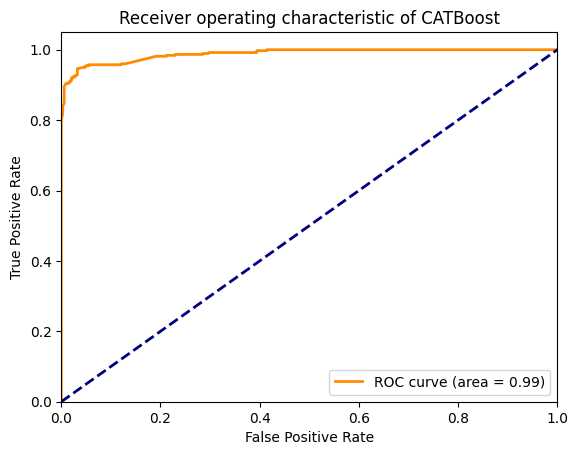

In [7]:
# prompt: generate curve for this

# Generate ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of CATBoost')
plt.legend(loc="lower right")
plt.show()


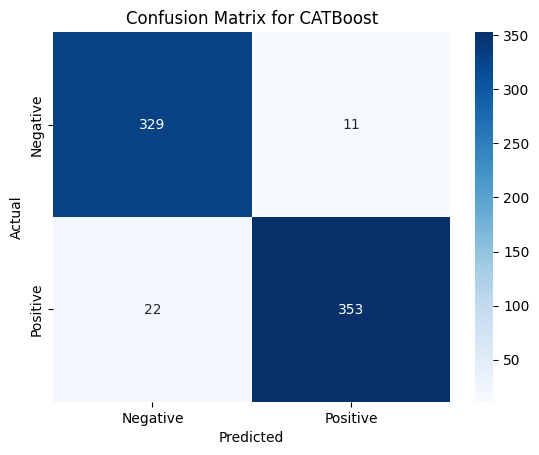

In [11]:
# prompt: confusion matrix for this

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CATBoost')

# Show the plot
plt.show()
